# Coursework 1
## MTH739P: Topics in Scientific Computing
### Gerardo Duran Martín 

In [57]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [1]:
using Plots
using LaTeXStrings

In [2]:
default(size=(600, 300))

## Question 1.

> Product the following four function plots, in the specified interval, using axis labels, a title and/or legend, and the specified number of points

a)

$$
    h(x) = \begin{cases}
    \frac{1}{x}\sin(x) & x\neq 0 \\
    1 & x = 0
    \end{cases}
$$

Using $n=100$ equally spaced points for $x\in[0, 2\pi]$. Display $h(x)$ with a dotted magenta line

In [3]:
function h(x)
    if x != 0
        return sin(x) / x
    else
        return 1
    end
end

h (generic function with 1 method)

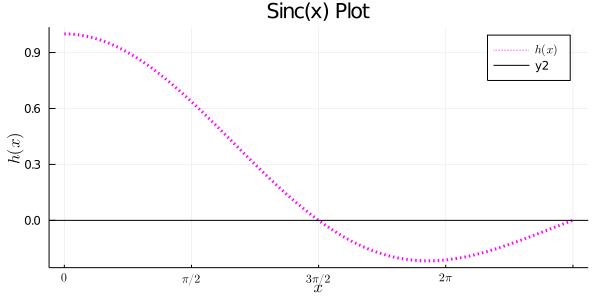

In [4]:
xvals = range(0, 2π, length=100)
xticks_labs = [L"0", L"\pi/2", L"3\pi/2", L"2\pi"]
xticks_vals = 0:π/2:2π

plot(xvals, h.(xvals), title="Sinc(x) Plot", label=L"h(x)",
    lw=3, c="magenta", linestyle=:dot,
    xticks=(xticks_vals, xticks_labs))
plot!([0], seriestype=:hline, c="black")
xlabel!(L"x")
ylabel!(L"h(x)")

b)

Produce a plot of the two functions

$$
    f(y) = y(2 y^2 - 5)(y^2 - 1)^{1/2} + 3 \log\left(y + (y^2 - 1)^{1/2}\right)
$$

$$
    g(y) = y (2 y ^ 2 - 1) (y^2 - 1)^{1/2} - \log(y + (y^2 - 1)^{1/2})
$$

In [5]:
function f(y)
    term = sqrt(y ^ 2 - 1)
    fval = y * (2 * y ^ 2 - 5) * term + 3 * log(y + term)
    return fval
end

function g(y)
    term = sqrt(y^2 - 1)
    gval = y * (2 * y ^ 2 - 1) * term - log(y + term)
    return gval
end

g (generic function with 1 method)

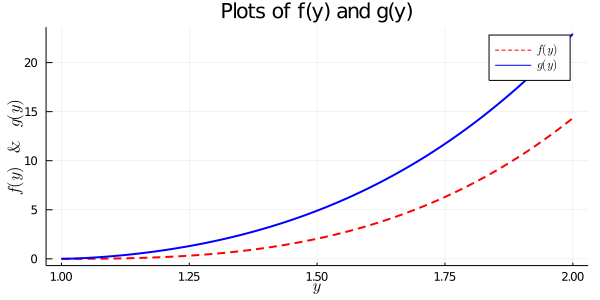

In [6]:
xvals = range(1, 2, length=100)
f_vals = f.(xvals)
g_vals = g.(xvals)

plot(xvals, f_vals, label=L"f(y)", c="red", style=:dash, lw=2)
plot!(xvals, g_vals, label=L"g(y)", c="blue", style=:solid, lw=2)
xlabel!(L"y")
ylabel!(L"f(y)\quad &\quad g(y)")
title!("Plots of f(y) and g(y)")

c)

Produce a parametric log-log plot of $s=f(y)$ as a function of $t=g(y)$, with $g(y)$ defined in `b)`, for $y\in[1, 2]$. Display the points $(t,s) = (g(y), f(y))$ in magenta

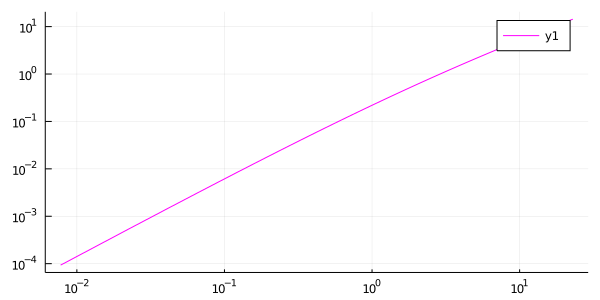

In [7]:
plot(g_vals[2:end], f_vals[2:end], xaxis=:log10, yaxis=:log10, c="magenta")

d)

Produce a plot of the two functions

$$
\begin{aligned}
    u(t) &= \cos(t)\\
    v(t) &= t
\end{aligned}
$$

For $t \in [0,1]$. Display $u(t)$ with a red solid line and $v(t)$ with green crosses

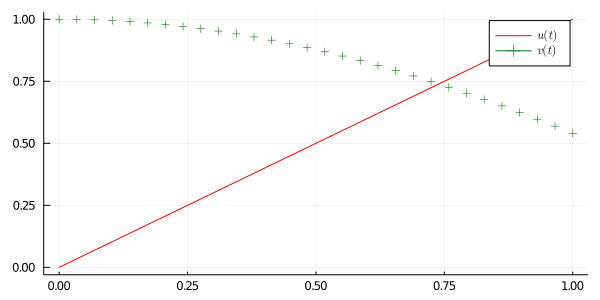

In [8]:
tvals = range(0, 1, length=30)
plot(tvals, tvals, c="red", label=L"u(t)")
plot!(tvals, cos.(tvals), c="green", marker=:cross, lw=0, label=L"v(t)")

## Question 2

In [9]:
x_old = 1.
eps = Inf

while eps > 10e-16
    x_new = cos(x_old)
    eps = abs(x_new - x_old)
    x_old = x_new
end

round(x_old, digits=16)

0.7390851332151603

In [10]:
x_old - cos(x_old)

-4.440892098500626e-16

## Question 3

## Question 4

In [55]:
new = [CartesianIndex()]
R = pi
N = 32
Δx = R / N

xi_values = (1:N+1 - 1 / 2) * Δx;

In [12]:
h_old = ones(N, 1);
M = Δx * (xi_values[new, :] .^ 2 ./ max.(xi_values[:, new], xi_values[new, :]) .- xi_values[new, :]);

l2_err = Inf
eps_err = 10e-14

while l2_err > eps_err
    h_new = 1 .+ M * h_old;
    errs = h_new - h_old;
    l2_err = sqrt(sum(errs .^ 2))
    h_old = h_new
end

h_new = h_old;

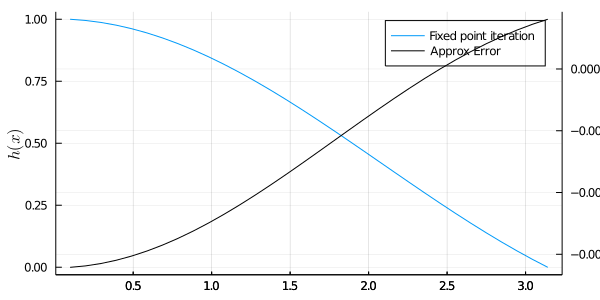

In [13]:
plot(xi_values, h_new, label="Fixed point iteration", ylabel=L"h(x)")
plot!(xi_values, NaN .* xi_values, label="Approx Error", c="black")
plot!(twinx(), xi_values, h.(xi_values) - h_new, legend=false, c="black")

## Question 5

## Question 6

We know that the Lagrange interpolation formula is given by

$$
    P_N(x) = \sum_{n=1}^N L_n(x) f(x_n)
$$

With

$$
    L_n(x) = \prod_{k\neq n}\frac{x - x_k}{x_n - x_k}
$$


This last equation implies that

$$
\frac{d}{dx} L_n(x) = \frac{\sum_{k\neq n} (x - x_k)}{\prod_{k\neq n} (x_n - x_k)}
$$

To prove (7), consider the set of three points $\{x_{n-1}, x_{n}, x_{n + 1}\}$

Suppose we have three equdistant points $\{x_{n-1}, x_n, x_{n + 1}\} = \{x_n - \Delta x, x_n, x_n + \Delta x\}$, then the lagrange interpolation formula becomes

$$
    P_3(x_n) = L_{n-1}(x_n) f(x_{n-1}) + L_{n}(x_n) f(x_{n}) + L_{n+1}(x_n) f(x_{n+1})
$$

With

$$
\begin{aligned}
    \frac{d}{dx}L_{n}(x_n)
    &= \frac{(x_{n} - x_{n-1}) + (x_{n} - x_{n+1})}{(x_{n} - x_{n-1})(x_{n} - x_{n+1})}\\
    &= \frac{\Delta x + -\Delta x}{(\Delta x)(-\Delta x)}\\
    &= 0 
\end{aligned}
$$


$$
\begin{aligned}
    \frac{d}{dx}L_{n-1}(x_n)
    &= \frac{(x_{n} - x_{n}) + (x_{n} - x_{n+1})}{(x_{n-1} - x_{n})(x_{n-1} - x_{n+1})} \\
    &= \frac{0 + -\Delta x}{(\Delta x)(-2\Delta x)}\\
    &= \frac{-1}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{n+1}(x_n)
    &= \frac{(x_{n} - x_{n}) + (x_{n} - x_{n-1})}{(x_{n+1} - x_{n})(x_{n+1} - x_{n-1})}\\
    &= \frac{0 + \Delta x}{(\Delta x)(2\Delta x)}\\
    &= \frac{1}{2\Delta x}
\end{aligned}
$$

Therefore

$$
\begin{aligned}
\frac{d}{dx}f(x_n) &= \frac{d}{dx}L_{n-1}(x_n)f(x_{n-1}) + \frac{d}{dx}L_{n}(x_n) f(x_n) + \frac{d}{dx}L_{n+1}(x_n) f(x_{n+1})\\
&= \frac{f(x_{n+1}) - f(x_{n-1})}{2\Delta x} + O(\Delta x^2)
\end{aligned}
$$

Next, to show the **left difference formula**, consider the set of equidistant points $\{x_0, x_1, x_2\} = \{x_0, x_0 + \Delta x,  x_0 + 2\Delta x\}$

and the values


$$
\begin{aligned}
    \frac{d}{dx}L_{0}(x_0)
    &= \frac{(x_{0} - x_{1}) + (x_{0} - x_{2})}{(x_{0} - x_{1})(x_{0} - x_{2})}\\
    &= \frac{-\Delta x -2\Delta x}{-\Delta x\cdot-2\Delta x}\\
    &= \frac{-3}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{1}(x_0)
    &= \frac{(x_{0} - x_{0}) + (x_{0} - x_{2})}{(x_{1} - x_{0})(x_{1} - x_{2})}\\
    &= \frac{0 - 2\Delta x}{\Delta x\cdot -\Delta x}\\
    &= \frac{4}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{2}(x_0)
    &= \frac{(x_{0} - x_{0}) + (x_{0} - x_{1})}{(x_{2} - x_{0})(x_{2} - x_{1})}\\
    &= \frac{0 - \Delta x}{2\Delta x\cdot\Delta x}\\
    &= \frac{1}{2\Delta x}
\end{aligned}
$$

Implies,

$$
\begin{aligned}
\frac{d}{dx} f(x_0) &= \frac{d}{dx}L_{0}(0)f(x_{0}) + \frac{d}{dx}L_{1}(x_0) f(x_1) + \frac{d}{dx}L_{2}(x_0) f(x_{2})  + O(\Delta x^2)\\
&= \frac{-3f(x_0) + 4 f(x_1) - f(x_2)}{2\Delta x}  + O(\Delta x^2)
\end{aligned}
$$

Finally, to show the **right difference formula**, consider the set of equidistant points $\{x_N, x_{N-1}, x_{N-2}\} = \{x_N, x_{N} - \Delta x, x_{N} - 2\Delta x\}$

and the values

$$
\begin{aligned}
    \frac{d}{dx}L_{N}(x_N)
    &= \frac{(x_{N} - x_{N-1}) + (x_{N} - x_{N-2})}{(x_{N} - x_{N-1})(x_{N} - x_{N-2})}\\
    &= \frac{\Delta x + 2\Delta x}{\Delta x\cdot 2\Delta x}\\
    &= \frac{3}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{N-1}(x_N)
    &= \frac{(x_{N} - x_{N}) + (x_{N} - x_{N-2})}{(x_{N-1} - x_{N})(x_{N-1} - x_{N-2})}\\
    &= \frac{0 - 2\Delta x}{-\Delta x\cdot -\Delta x}\\
    &= \frac{-4}{2\Delta x}
\end{aligned}
$$

$$
\begin{aligned}
    \frac{d}{dx}L_{N-2}(x_N)
    &= \frac{(x_{N} - x_{N}) + (x_{N} - x_{N-1})}{(x_{N-2} - x_{N})(x_{N-2} - x_{N-1})}\\
    &= \frac{0 + \Delta x}{2\Delta x\cdot \Delta x}\\
    &= \frac{1}{2\Delta x}
\end{aligned}
$$


Implies

$$
\begin{aligned}
\frac{d}{dx} f(x_N) &= \frac{d}{dx}L_{N}(x_N)f(x_{N}) + \frac{d}{dx}L_{N-1}(x_N) f(x_{N-1}) + \frac{d}{dx}L_{N-2}(x_N) f(x_{N-2}) + O(\Delta x^2)\\
&= \frac{f(x_{N-2}) - 4f(x_{N-1}) + 3 f(x_N)}{2\Delta x} + O(\Delta x^2)
\end{aligned}
$$

In [63]:
function latexL(n, i, j, m)
    val = "\\frac{(x_{$m} - x_{$i}) + (x_{$m} - x_{$j})}{(x_{$n} - x_{$i})(x_{$n} - x_{$j})}"
    print(val)
end

latexL("N-2", "N", "N-1", "N")

\frac{(x_{N} - x_{N}) + (x_{N} - x_{N-1})}{(x_{N-2} - x_{N})(x_{N-2} - x_{N-1})}

$$
    \frac{d}{dx}f(x) = \frac{f(x_{n+1}) - f(x_{n-1})}{2\Delta x} + O(\Delta x^2)
$$

In [14]:
function df(x::Float64)
    return -2.0 * exp(-x ^ 2.0)x
end

function f(x::Float64)
    return exp(-x ^ 2.0)
end

f (generic function with 2 methods)

In [15]:
function diffn(f0, f1, f2, Δx, n, N)
    if n == 1
        df = (-3.0 * f0 + 4.0 * f1 - f2) / (2.0 * Δx)
    elseif n == N
        df = (f0 - 4.0 * f1 + 3.0 * f2) / (2.0 * Δx)
    else
        df = (f2 - f0) / (2.0 * Δx)
    end 
    
    return df
end

function finite_diff(f_obs, Δx)
    """
    Implementatin of the finite differences method
    """
    n_obs = length(f_obs)
    f_prime = zeros(n_obs)
    
    for n in 1:n_obs
        if n >= n_obs - 1
            f0 = f_obs[n_obs - 2]
            f1 = f_obs[n_obs - 1]
            f2 = f_obs[n_obs]
        else
            f0 = f_obs[n]
            f1 = f_obs[n + 1]
            f2 = f_obs[n + 2]
        end
        
        df = diffn(f0, f1, f2, Δx, n, n_obs)
        f_prime[n] = df
    end
    
    return f_prime
end

finite_diff (generic function with 1 method)

In [16]:
N = 32
Δx = 2 / N
x_obs = -1:Δx:1
f_obs = f.(x_obs);

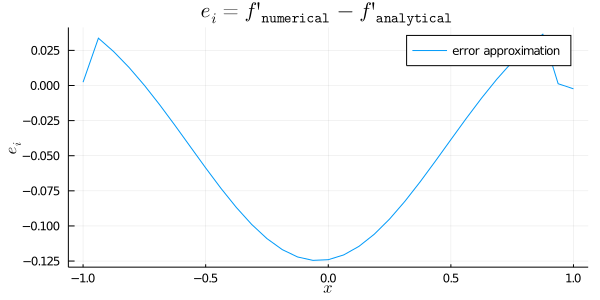

In [17]:
title = L"e_i = f'_\texttt{numerical} - f'_\texttt{analytical}"
df_approx = finite_diff(f_obs, Δx)
errs = df_approx - df.(x_obs)
p1 = plot(x_obs, errs,
    label="error approximation", title=title,
    xlabel=L"x", ylabel=L"e_i")

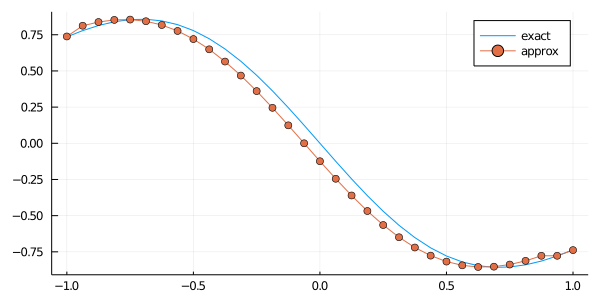

In [18]:
p2 = plot(x_obs, df.(x_obs), label="exact")
plot!(x_obs, df_approx, label="approx", marker=true)

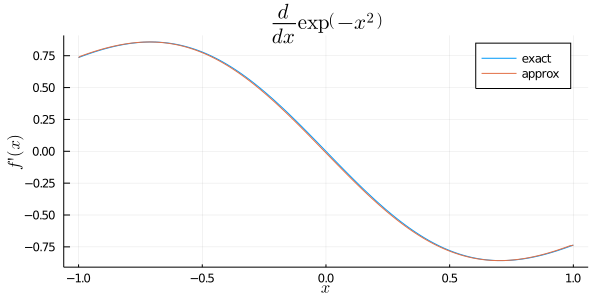

In [32]:
N = 320
Δx = 2 / N
x_obs = -1:Δx:1
f_obs = f.(x_obs);
df_approx = finite_diff(f_obs, Δx)

plot(x_obs, df.(x_obs), label="exact", xlabel=L"x", ylabel=L"f'(x)")
plot!(x_obs, df_approx, label="approx", title=L"\frac{d}{dx}\exp\left(-x^2\right)")

In [19]:
N_vals = 10:100
Δx_vals = 2 ./ N_vals

errors = zeros(length(N_vals))
for (n, N) in enumerate(N_vals)
    Δx = 2 / N
    x_obs = -1:Δx:1
    f_obs = f.(x_obs)
    df_approx = finite_diff(f_obs, Δx)
    err_n = df_approx - df.(x_obs)
    err_n = sum(abs.(err_n)) / N
    errors[n] = err_n
end

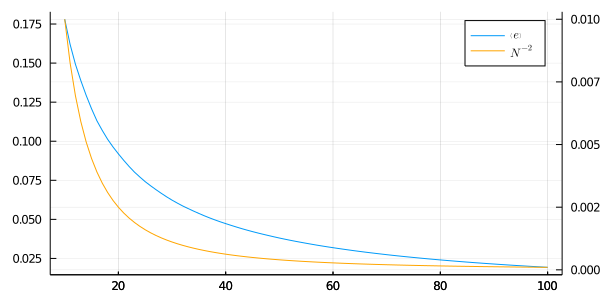

In [20]:
plot(N_vals, errors, label=L"\left\langle e \right\rangle")
plot!(N_vals, NaN .* N_vals,label=L"N^{-2}", c="orange")
plot!(twinx(), N_vals, 1 ./ N_vals .^ 2, legend=false, c="orange")

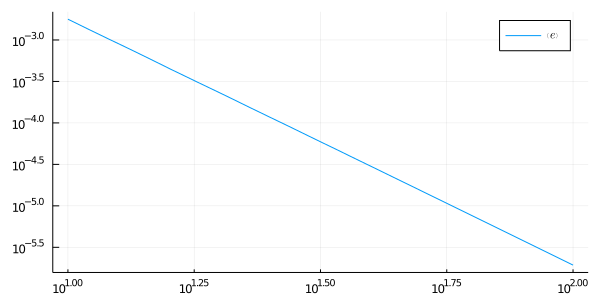

In [25]:
plot(N_vals, errors ./ N_vals .^ 2,
    label=L"\left\langle e \right\rangle",
    xaxis=:log10, yaxis=:log10)